In [3]:
import json
import pandas as pd
from datasets import load_dataset
import getpass
import os
import time

import requests
from tavily import TavilyClient


In [4]:
with open("/Users/ankushgarg/Downloads/climate_comments.json", 'r') as json_file:
    json_data = json.load(json_file)


In [5]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

In [6]:
_set_env("TAVILY_API_KEY")

In [7]:
import logging
import operator
from typing import Annotated, List, Optional, TypedDict, Sequence
from langchain_core.messages import BaseMessage

logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("reddit-comments")

class State(TypedDict):
    prompts: Annotated[Sequence[BaseMessage], operator.add]
    input: Annotated[Sequence[BaseMessage], operator.add]
    replies: Annotated[Sequence[BaseMessage], operator.add]
    keywords: Annotated[Sequence[BaseMessage], operator.add]
    article_search: Annotated[Sequence[BaseMessage], operator.add]
    comment_summaries: Annotated[Sequence[BaseMessage], operator.add]
    generated_reply: Annotated[Sequence[BaseMessage], operator.add]


In [8]:
from langchain_anthropic import ChatAnthropic
llm = ChatAnthropic(model='claude-3-haiku-20240307')

In [19]:
def extract_keywords_from_title(state: State):
    input = state["input"][-1]
    
    prompt = f"""Extract two most important keywords from the input. Please return them as a Python list of strings. Don't include any preamble, just the keywords in your response.
    input: {input}
    """ # We extracted two keywords from the title

    response = llm.invoke(prompt)
    return {"keywords":[response.content], "prompts": [prompt]}

def tool_search(state: State):
    keywords = state["keywords"][-1]
    prompt = f"Based on these keywords: {keywords}, please search for an article on the web."
        
    tavily_client = TavilyClient(api_key=os.getenv("TAVILY_API_KEY"))
    response = tavily_client.search(prompt, max_results=1, include_raw_content=True)

    results = {
        "url": response['results'][0]['url'],
        "content": response['results'][0]['raw_content']
        }

    return {"article_search": [results], "prompts": [prompt]}


def summarize_tone_sentiment_of_replies(state: State):
    content = state["replies"]

    prompt = f"""Your goal is to extract a tone (single), sentiment (single) and summary (less than 100 words) the main point the comments are making. Analyze and output in JSON format with keys: "tone" (tone), "sentiment" (positive or negative), "summary" (main point the replies are making).
    input: {content}
    """
    response = llm.invoke(prompt)
    return {"comment_summaries":[response.content], "prompts": [prompt]}

def generate_reply(state: State):
    url = ""
    content = ""
    tone = ""
    sentiment = ""
    summary = ""

    try: 
        article_search = state.get("article_search")[0]
        url = article_search['url']
        content = article_search['content']
    except Exception as e:
        print(e)
        
    try:
        comment_summaries = json.loads(state.get("comment_summaries")[0])
        tone = comment_summaries['tone']
        sentiment = comment_summaries['sentiment']
        summary = comment_summaries['summary']
        
    except Exception as e:
        print(e)

    prompt = f"""Your job is to write a reddit reply (in less than 100 words) in {tone} tone to some other comments summarized here - {summary}.
    Even though you're replying to the other comments, your reply must contain content from this article - {content} and sound original. Make sure to include the link to the url {url} in the reply itself. 
    Special instructions: No need to include a heading or any preamble, just report the comment.
"""
    response = llm.invoke(prompt)
    return {"generated_reply":[response.content], "prompts": [prompt]}


In [20]:
from langgraph.graph import StateGraph, Graph, START, END

workflow = StateGraph(State)

workflow.add_node("extract_keywords_from_title", extract_keywords_from_title)
workflow.add_node("tool_search", tool_search)
workflow.add_node("summarize_tone_sentiment_of_replies", summarize_tone_sentiment_of_replies)
workflow.add_node("generate_reply", generate_reply)

workflow.add_edge(START, "extract_keywords_from_title")

workflow.add_edge("extract_keywords_from_title", "tool_search")
workflow.add_edge("tool_search", "summarize_tone_sentiment_of_replies")
workflow.add_edge("summarize_tone_sentiment_of_replies", "generate_reply")
workflow.add_edge("generate_reply", END)

graph = workflow.compile()

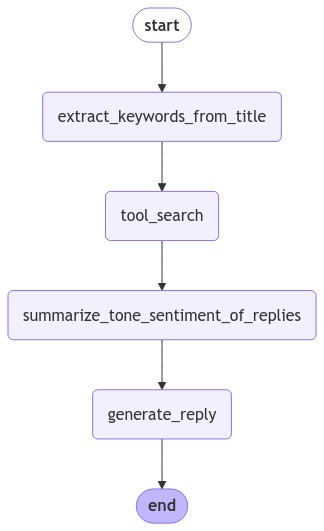

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)
    # This requires some extra dependencies and is optional
    pass

In [22]:
def write_to_file(response, post_id_):
    previous_responses = pd.read_excel("reddit-comments-eval.xlsx", sheet_name="Sheet1")

    try:
        post_id = {f"post_id": post_id_}
        prompts = {f"prompt-{idx+1}": r for idx, r in enumerate(response['prompts'])}
        input = {f"input-post": r for _, r in enumerate(response['input'])}
        replies = {f"input-replies": [r for idx, r in enumerate(response['replies'])]}
        keywords = {f"output-keywords": response["keywords"]}
        article_search = {f"output-article_search" : response['article_search']}
        output_replies = {f"output-replies": json.loads(response['comment_summaries'][0])}
        reply = {f"output-reply": response["generated_reply"]}

        response_df = pd.DataFrame([{
            **post_id,
            **prompts, 
            **input, 
            **replies, 
            **keywords,
            **article_search,
            **output_replies,
            **reply
            }]) 
        
        updated_responses = pd.concat([previous_responses, response_df])
        updated_responses.to_excel("reddit-comments-eval.xlsx", sheet_name="Sheet1", index=False)

    except Exception as e:
        print(f"Got an error in {post_id}. Error: {e}")
        error_dataframe = pd.DataFrame({"error": [e], 'post_id': [post_id_]})        
        updated_responses = pd.concat([previous_responses, error_dataframe])
        updated_responses.to_excel("reddit-comments-eval.xlsx", sheet_name="Sheet1", index=False)


In [27]:
start = 21
end = 40

responses = {}
for post in json_data['Posts'][start:end]:
    post_id = post['PostID']
    post_title = [post['PostTitle']]
    comments = [i['CommentBody'] for i in post['Comments']]
    
    response = graph.invoke({
        "input": post_title,
        "replies": comments
        })
    responses[str(post_id)] = response



Expecting ',' delimiter: line 4 column 54 (char 104)


In [28]:
for post_id, response in responses.items():
    write_to_file(response=response, post_id_=post_id)

Got an error in {'post_id': 'wiciv8'}. Error: Expecting ',' delimiter: line 4 column 54 (char 104)


In [69]:
{"url": response['results'][0]['url'], "content": response['results'][0]['raw_content']}

{'url': 'https://ahrefs.com/blog/keyword-research/',
 'content': "How to Do Keyword Research for\xa0SEO\nThe number of websites linking to this post.\nThis post's estimated monthly organic search traffic.\nThat’s why mastering the art of keyword research is so important for your success in SEO. The cost of making a mistake is just too high. Pick the wrong keywords, and you risk wasting lots of your time and resources.\nAnd I don’t mean to intimidate you. Keyword research is not rocket science. In fact, you’re about to learn most of it in just about 20 minutes. But there are quite a few important caveats and misconceptions that you need to be aware of in order to make better SEO decisions.\nSo let’s dive right\xa0in.\nKeyword research basics\nKeyword research basics\nIf you’re new to SEO, you’re probably wondering what keyword research even is and why it is so important. Well, this short chapter is for you. Otherwise, just skip to the next\xa0one.\nWhat is keyword research?\nKeyword res